# MultiAgent Pattern

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## The Agent Class

#### General Helpers

In [2]:
from utils import (
    completions_create,
    build_prompt_structure,
    update_chat_history,
    ChatHistory,
    FixedFirstChatHistory,
    fancy_print,
    get_fn_signature,
    validate_arguments,
    Tool,
    tool,
    extract_tag_content,
    TagContentResult
)

#### Tools

In [3]:
from react import ReactAgent

In [4]:
from openai import OpenAI
from textwrap import dedent
from react import Crew  # prevents undefined Crew when using agent solo


class Agent:
    """
    Represents an AI agent that can work as part of a team to complete tasks.

    This class implements an agent with dependencies, context handling, and task execution capabilities.
    It can be used in a multi-agent system where agents collaborate to solve complex problems.

    Attributes:
        name (str): The name of the agent.
        backstory (str): The backstory or background of the agent.
        task_description (str): A description of the task assigned to the agent.
        task_expected_output (str): The expected format or content of the task output.
        react_agent (ReactAgent): An instance of ReactAgent used for generating responses.
        dependencies (list[Agent]): A list of Agent instances that this agent depends on.
        dependents (list[Agent]): A list of Agent instances that depend on this agent.
        context (str): Accumulated context information from other agents.

    Args:
        name (str): The name of the agent.
        backstory (str): The backstory or background of the agent.
        task_description (str): A description of the task assigned to the agent.
        task_expected_output (str, optional): The expected format or content of the task output. Defaults to "".
        tools (list[Tool] | None, optional): A list of Tool instances available to the agent. Defaults to None.
        llm (str, optional): The name of the language model to use. Defaults to "gpt-4o".
    """

    def __init__(
        self,
        name: str,
        backstory: str,
        task_description: str,
        task_expected_output: str = "",
        tools: list[Tool] | None = None,
        llm: str = "gpt-4o",
    ):
        self.name = name
        self.backstory = backstory
        self.task_description = task_description
        self.task_expected_output = task_expected_output
        self.react_agent = ReactAgent(
            model=llm, system_prompt=self.backstory, tools=tools or []
        )

        self.dependencies: list[Agent] = []  # Agents that this agent depends on
        self.dependents: list[Agent] = []  # Agents that depend on this agent

        self.context = ""

        # Automatically register this agent to the active Crew context if one exists
        Crew.register_agent(self)

    def __repr__(self):
        return f"{self.name}"

    def __rshift__(self, other):
        """
        Defines the '>>' operator. This operator is used to indicate agent dependency.

        Args:
            other (Agent): The agent that depends on this agent.
        """
        self.add_dependent(other)
        return other  # Allow chaining

    def __lshift__(self, other):
        """
        Defines the '<<' operator to indicate agent dependency in reverse.

        Args:
            other (Agent): The agent that this agent depends on.

        Returns:
            Agent: The `other` agent to allow for chaining.
        """
        self.add_dependency(other)
        return other  # Allow chaining

    def __rrshift__(self, other):
        """
        Defines the '<<' operator.This operator is used to indicate agent dependency.

        Args:
            other (Agent): The agent that this agent depends on.
        """
        self.add_dependency(other)
        return self  # Allow chaining

    def __rlshift__(self, other):
        """
        Defines the '<<' operator when evaluated from right to left.
        This operator is used to indicate agent dependency in the normal order.

        Args:
            other (Agent): The agent that depends on this agent.

        Returns:
            Agent: The current agent (self) to allow for chaining.
        """
        self.add_dependent(other)
        return self  # Allow chaining

    def add_dependency(self, other):
        """
        Adds a dependency to this agent.

        Args:
            other (Agent | list[Agent]): The agent(s) that this agent depends on.

        Raises:
            TypeError: If the dependency is not an Agent or a list of Agents.
        """
        if isinstance(other, Agent):
            self.dependencies.append(other)
            other.dependents.append(self)
        elif isinstance(other, list) and all(isinstance(item, Agent) for item in other):
            for item in other:
                self.dependencies.append(item)
                item.dependents.append(self)
        else:
            raise TypeError("The dependency must be an instance or list of Agent.")

    def add_dependent(self, other):
        """
        Adds a dependent to this agent.

        Args:
            other (Agent | list[Agent]): The agent(s) that depend on this agent.

        Raises:
            TypeError: If the dependent is not an Agent or a list of Agents.
        """
        if isinstance(other, Agent):
            other.dependencies.append(self)
            self.dependents.append(other)
        elif isinstance(other, list) and all(isinstance(item, Agent) for item in other):
            for item in other:
                item.dependencies.append(self)
                self.dependents.append(item)
        else:
            raise TypeError("The dependent must be an instance or list of Agent.")

    def receive_context(self, input_data):
        """
        Receives and stores context information from other agents.

        Args:
            input_data (str): The context information to be added.
        """
        self.context += f"{self.name} received context: \n{input_data}"

    def create_prompt(self):
        """
        Creates a prompt for the agent based on its task description, expected output, and context.

        Returns:
            str: The formatted prompt string.
        """
        prompt = dedent(
            f"""
        You are an AI agent. You are part of a team of agents working together to complete a task.
        I'm going to give you the task description enclosed in <task_description></task_description> tags. I'll also give
        you the available context from the other agents in <context></context> tags. If the context
        is not available, the <context></context> tags will be empty. You'll also receive the task
        expected output enclosed in <task_expected_output></task_expected_output> tags. With all this information
        you need to create the best possible response, always respecting the format as describe in
        <task_expected_output></task_expected_output> tags. If expected output is not available, just create
        a meaningful response to complete the task.

        <task_description>
        {self.task_description}
        </task_description>

        <task_expected_output>
        {self.task_expected_output}
        </task_expected_output>

        <context>
        {self.context}
        </context>

        Your response:
        """
        ).strip()

        return prompt

    def run(self):
        """
        Runs the agent's task and generates the output.

        This method creates a prompt, runs it through the ReactAgent, and passes the output to all dependent agents.

        Returns:
            str: The output generated by the agent.
        """
        msg = self.create_prompt()
        output = self.react_agent.run(user_msg=msg)

        # Pass the output to all dependents
        for dependent in self.dependents:
            dependent.receive_context(output)
        return output


In [5]:
agent_example = Agent(
    name="Poet Agent",
    backstory="You are a well-known poet, who enjoys creating high quality poetry.",
    task_description="Write a poem about the meaning of life in less than 6 lines",
    task_expected_output="Just output the poem, without any title or introductory sentences",
)

In [6]:
print(agent_example.run())

In fleeting moments, time reveals,  
The dance of stars, where fate conceals,  
In love's embrace and sorrow's light,  
Life's essence shines in day and night.  
Through endless dreams and whispered air,  
We find our meaning, growing rare.  


In [7]:
from tools import write_str_to_txt

In [8]:
agent_tool_example = Agent(
    name="Writer Agent",
    backstory="You are a language model specialised in writing text into .txt files",
    task_description="Write the string 'This is a Tool Agent' into './tool_agent_example.txt'",
    task_expected_output="A .txt file containing the given string",
    tools=write_str_to_txt,
)

In [9]:
agent_tool_example.run()


Thought: The task requires writing a specific string into a text file. The task expected output describes creating a .txt file with the given string.

Using Tool: write_str_to_txt

Tool call dict: 
{'name': 'write_str_to_txt', 'arguments': {'string_data': 'This is a Tool Agent', 'txt_filename': './tool_agent_example.txt'}, 'id': 0}
Data successfully written to ./tool_agent_example.txt

Tool result: 
None

Observations: {0: None}


"File './tool_agent_example.txt' has been successfully created with the specified content."

####  Defining Agent Dependencies

Let's define two agents now.


In [10]:
agent_1 = Agent(
    name="Poet Agent",
    backstory="You are a well-known poet, who enjoys creating high quality poetry.",
    task_description="Write a poem about the meaning of life in 4 lines",
    task_expected_output="Just output the poem, without any title or introductory sentences",
)

agent_2 = Agent(
    name="Poem Translator Agent",
    backstory="You are an expert translator especially skilled in Ancient Greek",
    task_description="Translate a poem into Ancient Greek",
    task_expected_output="Just output the translated poem and nothing else"
)

We can define the agent dependencies using the `>>` operator.

In [11]:
agent_1 >> agent_2

Poem Translator Agent

This means `agent_2` depends on `agent_1`. We can check the dependencies and dependents of both agents.

In [12]:
print("Agent 1 dependencies: ", agent_1.dependencies)
print("Agent 1 dependents: ", agent_1.dependents)
print("Agent 2 dependencies: ", agent_2.dependencies)
print("Agent 2 dependents: ", agent_2.dependents)

Agent 1 dependencies:  []
Agent 1 dependents:  [Poem Translator Agent]
Agent 2 dependencies:  [Poet Agent]
Agent 2 dependents:  []


Now, if we run `agent_1`, the results will be added to `agent_2`'s context.

In [13]:
print(agent_1.run())

In the quiet breath of dawn's embrace,  
Life whispers secrets in a gentle trace,  
Moments weave like threads in cosmic loom,  
In love and wonder, souls find room.


In [14]:
print(agent_2.context)

Poem Translator Agent received context: 
In the quiet breath of dawn's embrace,  
Life whispers secrets in a gentle trace,  
Moments weave like threads in cosmic loom,  
In love and wonder, souls find room.


Now, if we run the second agent, it will use the context received from the previous agent to generate its output.

In [15]:
print(agent_2.run())

Ἐν τῇ ἡσυχίᾳ ἀνατολῆς ἀγκαλιάσματος,  
Ζωὴ ψιθυρίζει μυστήρια ἐν ἁπαλῇ ἴχνει,  
Στιγμαὶ ὑφαίνονται ὥσπερ κλωστὰς ἐν τῷ κοσμικῷ ἀργαλειῷ,  
Ἐν ἔρωτι καὶ θαύματι, ψυχαὶ εὑρίσκουσιν τόπον.


## The Crew

In [16]:
from collections import deque
from graphviz import Digraph  # type: ignore
from colorama import Fore


class Crew:
    """
    A class representing a crew of agents working together.

    This class manages a group of agents, their dependencies, and provides methods
    for running the agents in a topologically sorted order.

    Attributes:
        current_crew (Crew): Class-level variable to track the active Crew context.
        agents (list): A list of agents in the crew.
    """

    current_crew = None

    def __init__(self):
        self.agents = []

    def __enter__(self):
        """
        Enters the context manager, setting this crew as the current active context.

        Returns:
            Crew: The current Crew instance.
        """
        Crew.current_crew = self
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """
        Exits the context manager, clearing the active context.

        Args:
            exc_type: The exception type, if an exception was raised.
            exc_val: The exception value, if an exception was raised.
            exc_tb: The traceback, if an exception was raised.
        """
        Crew.current_crew = None

    def add_agent(self, agent):
        """
        Adds an agent to the crew.

        Args:
            agent: The agent to be added to the crew.
        """
        self.agents.append(agent)

    @staticmethod
    def register_agent(agent):
        """
        Registers an agent with the current active crew context.

        Args:
            agent: The agent to be registered.
        """
        if Crew.current_crew is not None:
            Crew.current_crew.add_agent(agent)

    def topological_sort(self):
        """
        Performs a topological sort of the agents based on their dependencies.

        Returns:
            list: A list of agents sorted in topological order.

        Raises:
            ValueError: If there's a circular dependency among the agents.
        """
        in_degree = {agent: len(agent.dependencies) for agent in self.agents}
        queue = deque([agent for agent in self.agents if in_degree[agent] == 0])

        sorted_agents = []

        while queue:
            current_agent = queue.popleft()
            sorted_agents.append(current_agent)

            for dependent in current_agent.dependents:
                in_degree[dependent] -= 1
                if in_degree[dependent] == 0:
                    queue.append(dependent)

        if len(sorted_agents) != len(self.agents):
            raise ValueError(
                "Circular dependencies detected among agents, preventing a valid topological sort"
            )

        return sorted_agents

    def plot(self):
        """
        Plots the Directed Acyclic Graph (DAG) of agents in the crew using Graphviz.

        Returns:
            Digraph: A Graphviz Digraph object representing the agent dependencies.
        """
        dot = Digraph(format="png")  # Set format to PNG for inline display

        # Add nodes and edges for each agent in the crew
        for agent in self.agents:
            dot.node(agent.name)
            for dependency in agent.dependencies:
                dot.edge(dependency.name, agent.name)
        return dot

    def run(self):
        """
        Runs all agents in the crew in topologically sorted order.

        This method executes each agent's run method and prints the results.
        """
        sorted_agents = self.topological_sort()
        for agent in sorted_agents:
            fancy_print(f"RUNNING AGENT: {agent}")
            print(Fore.RED + f"{agent.run()}")


Let's define a sequential crew of agents now.

In [17]:
with Crew() as crew:
    agent_1 = Agent(
        name="Poet Agent",
        backstory="You are a well-known poet, who enjoys creating high quality poetry.",
        task_description="Write a poem about the meaning of life in less than 6 lines",
        task_expected_output="Just output the poem, without any title or introductory sentences",
    )

    agent_2 = Agent(
        name="Poem Translator Agent",
        backstory="You are an expert translator especially skilled in Spanish",
        task_description="Translate a poem into Spanish",
        task_expected_output="Just output the translated poem and nothing else"
    )

    agent_3 = Agent(
        name="Writer Agent",
        backstory="You are an expert transcriber, that loves writing poems into txt files",
        task_description="You'll receive a Spanish poem in your context. You need to write the poem into './poem.txt' file",
        task_expected_output="A txt file containing the Spanish poem received from the context",
        tools=write_str_to_txt,
    )

    agent_1 >> agent_2 >> agent_3

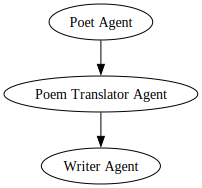

In [18]:
crew.plot()

In [19]:
crew.run()


RUNNING AGENT: Poet Agent

In fleeting whispers life does dance,  
Through loves embraced and moments chanced.  
In shadowed depths and skies of light,  
We seek our truths, both day and night.  
Life's meaning rests in hearts entwined,  
Where joy and sorrow life define.  

RUNNING AGENT: Poem Translator Agent

En susurros fugaces la vida danza,  
A través de amores abrazados y momentos al azar.  
En profundidades sombrías y cielos de luz,  
Buscamos nuestras verdades, tanto de día como de noche.  
El significado de la vida descansa en corazones entrelazados,  
Donde la alegría y el dolor definen la vida.

RUNNING AGENT: Writer Agent


Thought: I need to write the provided Spanish poem into a text file named 'poem.txt'.

Using Tool: write_str_to_txt

Tool call dict: 
{'name': 'write_str_to_txt', 'arguments': {'string_data': 'En susurros fugaces la vida danza,  \nA través de amores abrazados y momentos al azar.  \nEn profundidades sombrías y cielos de luz,  \nBuscamos nuestras verdade